# Import

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-03-08 23:14:42.943475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 23:14:42.943514: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# VAE Base Model

## Class Sampling

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Encoder

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

## Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

## Define VAE as a Model

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train VAE Model

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=5, batch_size=128)

In [ ]:
mnist_digits.shape

## Display Sample

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)


## Latent Space Cluster

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)


# VAE Smile Model

## Class Sampling

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [3]:
latent_dim = 64

encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 128)  73856       ['conv2d_1[0][0]']         

2022-03-07 22:08:32.776953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-07 22:08:32.777202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 22:08:32.777272: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-07 22:08:32.777332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-07 22:08:32.777389: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

## Decoder

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 8192)              532480    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 32)       1846

## Define VAE as a Model

In [3]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Train Smile Model

## Get Data

In [4]:
from icangetyoursmile.utils import get_dataset_tts_from_local

In [5]:
path = "../../raw_data"

X, y, X_test, y_test, X_visu, y_visu = get_dataset_tts_from_local(path, image_size=(128,128), sample_size=3000)

Loading data from ../../raw_data/128x128/...
Done
X shape : (2550, 128, 128, 3)
y shape : (2550, 128, 128, 3)
X_test shape : (450, 128, 128, 3)
y_test shape : (450, 128, 128, 3)
X_visu shape : (5, 128, 128, 3)
y_visu shape : (5, 128, 128, 3)


In [6]:
X_st = y.astype("float32") / 255

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [74]:
vae

In [10]:
epochs = 2000
batch_size = 128

In [11]:
history = vae.fit(X_st, epochs=epochs, batch_size=batch_size)

Epoch 1/2000
20/20 [==============================] - 16s 634ms/step - loss: 3209.2361 - reconstruction_loss: 3160.2271 - kl_loss: 0.8400
Epoch 2/2000
20/20 [==============================] - 13s 672ms/step - loss: 3038.0140 - reconstruction_loss: 3021.3804 - kl_loss: 2.2708
Epoch 3/2000
20/20 [==============================] - 13s 669ms/step - loss: 2777.7861 - reconstruction_loss: 2699.5579 - kl_loss: 20.2156
Epoch 4/2000
20/20 [==============================] - 13s 650ms/step - loss: 2587.1408 - reconstruction_loss: 2527.4731 - kl_loss: 19.9969
Epoch 5/2000
20/20 [==============================] - 13s 660ms/step - loss: 2415.2262 - reconstruction_loss: 2348.9231 - kl_loss: 32.3538
Epoch 6/2000
20/20 [==============================] - 13s 636ms/step - loss: 2241.9297 - reconstruction_loss: 2160.0840 - kl_loss: 37.7076
Epoch 7/2000
20/20 [==============================] - 13s 628ms/step - loss: 1998.8699 - reconstruction_loss: 1937.9875 - kl_loss: 39.1387
Epoch 8/2000
20/20 [=========

20/20 [==============================] - 13s 638ms/step - loss: 1183.4744 - reconstruction_loss: 1116.2034 - kl_loss: 73.3559
Epoch 118/2000
20/20 [==============================] - 13s 664ms/step - loss: 1195.8773 - reconstruction_loss: 1113.0931 - kl_loss: 73.4253
Epoch 119/2000
20/20 [==============================] - 13s 648ms/step - loss: 1182.2812 - reconstruction_loss: 1113.5730 - kl_loss: 73.2698
Epoch 120/2000
20/20 [==============================] - 13s 647ms/step - loss: 1185.0427 - reconstruction_loss: 1109.8107 - kl_loss: 73.7171
Epoch 121/2000
20/20 [==============================] - 13s 644ms/step - loss: 1177.6826 - reconstruction_loss: 1104.8529 - kl_loss: 73.3401
Epoch 122/2000
20/20 [==============================] - 13s 649ms/step - loss: 1172.7207 - reconstruction_loss: 1104.7401 - kl_loss: 73.3363
Epoch 123/2000
20/20 [==============================] - 13s 643ms/step - loss: 1188.8368 - reconstruction_loss: 1117.1835 - kl_loss: 72.4751
Epoch 124/2000
20/20 [======

20/20 [==============================] - 13s 648ms/step - loss: 1074.1311 - reconstruction_loss: 1010.0125 - kl_loss: 70.9260
Epoch 234/2000
20/20 [==============================] - 13s 652ms/step - loss: 1082.3454 - reconstruction_loss: 1009.6417 - kl_loss: 70.7626
Epoch 235/2000
20/20 [==============================] - 13s 649ms/step - loss: 1088.3599 - reconstruction_loss: 1015.7039 - kl_loss: 70.2042
Epoch 236/2000
20/20 [==============================] - 13s 666ms/step - loss: 1082.3525 - reconstruction_loss: 1013.8753 - kl_loss: 70.3492
Epoch 237/2000
20/20 [==============================] - 13s 658ms/step - loss: 1085.7144 - reconstruction_loss: 1012.2108 - kl_loss: 70.7253
Epoch 238/2000
20/20 [==============================] - 13s 648ms/step - loss: 1078.8643 - reconstruction_loss: 1011.2062 - kl_loss: 70.0811
Epoch 239/2000
20/20 [==============================] - 13s 648ms/step - loss: 1077.1521 - reconstruction_loss: 1008.8853 - kl_loss: 70.6187
Epoch 240/2000
20/20 [======

20/20 [==============================] - 13s 644ms/step - loss: 1025.0938 - reconstruction_loss: 963.2152 - kl_loss: 67.5439
Epoch 350/2000
20/20 [==============================] - 13s 651ms/step - loss: 1025.1037 - reconstruction_loss: 962.9860 - kl_loss: 67.7626
Epoch 351/2000
20/20 [==============================] - 13s 650ms/step - loss: 1025.6451 - reconstruction_loss: 961.0824 - kl_loss: 67.7934
Epoch 352/2000
20/20 [==============================] - 13s 649ms/step - loss: 1029.8156 - reconstruction_loss: 961.9760 - kl_loss: 67.4221
Epoch 353/2000
20/20 [==============================] - 13s 650ms/step - loss: 1025.2135 - reconstruction_loss: 960.4229 - kl_loss: 67.5392
Epoch 354/2000
20/20 [==============================] - 13s 646ms/step - loss: 1033.3230 - reconstruction_loss: 968.5511 - kl_loss: 67.2556
Epoch 355/2000
20/20 [==============================] - 13s 648ms/step - loss: 1029.6820 - reconstruction_loss: 962.4905 - kl_loss: 67.4808
Epoch 356/2000
20/20 [=============

20/20 [==============================] - 13s 661ms/step - loss: 990.9229 - reconstruction_loss: 936.7557 - kl_loss: 63.9102
Epoch 466/2000
20/20 [==============================] - 13s 652ms/step - loss: 1011.8369 - reconstruction_loss: 950.3160 - kl_loss: 63.1712
Epoch 467/2000
20/20 [==============================] - 13s 669ms/step - loss: 1001.6424 - reconstruction_loss: 937.9877 - kl_loss: 63.7034
Epoch 468/2000
20/20 [==============================] - 13s 674ms/step - loss: 996.1487 - reconstruction_loss: 935.1258 - kl_loss: 64.0908
Epoch 469/2000
20/20 [==============================] - 13s 661ms/step - loss: 993.7445 - reconstruction_loss: 930.5208 - kl_loss: 63.7848
Epoch 470/2000
20/20 [==============================] - 13s 673ms/step - loss: 995.9342 - reconstruction_loss: 931.9450 - kl_loss: 63.6938
Epoch 471/2000
20/20 [==============================] - 13s 657ms/step - loss: 1011.7314 - reconstruction_loss: 948.7083 - kl_loss: 62.9908
Epoch 472/2000
20/20 [=================

20/20 [==============================] - 14s 705ms/step - loss: 974.6743 - reconstruction_loss: 916.2121 - kl_loss: 62.8340
Epoch 583/2000
20/20 [==============================] - 14s 680ms/step - loss: 973.6888 - reconstruction_loss: 919.0596 - kl_loss: 62.9401
Epoch 584/2000
20/20 [==============================] - 13s 673ms/step - loss: 977.5121 - reconstruction_loss: 916.9043 - kl_loss: 62.8859
Epoch 585/2000
20/20 [==============================] - 13s 673ms/step - loss: 980.4733 - reconstruction_loss: 916.8292 - kl_loss: 62.9045
Epoch 586/2000
20/20 [==============================] - 14s 683ms/step - loss: 978.2097 - reconstruction_loss: 919.4122 - kl_loss: 62.7679
Epoch 587/2000
20/20 [==============================] - 14s 681ms/step - loss: 980.1310 - reconstruction_loss: 916.5897 - kl_loss: 63.1044
Epoch 588/2000
20/20 [==============================] - 14s 714ms/step - loss: 974.0947 - reconstruction_loss: 911.6244 - kl_loss: 63.4295
Epoch 589/2000
20/20 [====================

20/20 [==============================] - 13s 663ms/step - loss: 972.3756 - reconstruction_loss: 911.2429 - kl_loss: 62.4551
Epoch 642/2000
20/20 [==============================] - 13s 668ms/step - loss: 970.1706 - reconstruction_loss: 905.8048 - kl_loss: 62.7668
Epoch 643/2000
20/20 [==============================] - 14s 675ms/step - loss: 965.9831 - reconstruction_loss: 904.7662 - kl_loss: 62.4269
Epoch 644/2000
20/20 [==============================] - 14s 687ms/step - loss: 968.4686 - reconstruction_loss: 906.6558 - kl_loss: 62.8277
Epoch 645/2000
20/20 [==============================] - 13s 662ms/step - loss: 975.0845 - reconstruction_loss: 911.9067 - kl_loss: 62.4529
Epoch 646/2000
20/20 [==============================] - 13s 659ms/step - loss: 976.3450 - reconstruction_loss: 911.3511 - kl_loss: 62.5635
Epoch 647/2000
20/20 [==============================] - 13s 671ms/step - loss: 969.6293 - reconstruction_loss: 913.5373 - kl_loss: 62.1120
Epoch 648/2000
20/20 [====================

20/20 [==============================] - 13s 666ms/step - loss: 960.4375 - reconstruction_loss: 900.2806 - kl_loss: 62.1915
Epoch 701/2000
20/20 [==============================] - 13s 660ms/step - loss: 960.2867 - reconstruction_loss: 897.5975 - kl_loss: 62.4592
Epoch 702/2000
20/20 [==============================] - 13s 674ms/step - loss: 963.6865 - reconstruction_loss: 896.9723 - kl_loss: 62.4500
Epoch 703/2000
20/20 [==============================] - 14s 689ms/step - loss: 959.7794 - reconstruction_loss: 909.2297 - kl_loss: 62.1723
Epoch 704/2000
20/20 [==============================] - 14s 695ms/step - loss: 967.2006 - reconstruction_loss: 905.4482 - kl_loss: 62.1922
Epoch 705/2000
20/20 [==============================] - 14s 685ms/step - loss: 954.9375 - reconstruction_loss: 902.6689 - kl_loss: 62.5001
Epoch 706/2000
20/20 [==============================] - 14s 699ms/step - loss: 961.8739 - reconstruction_loss: 901.3026 - kl_loss: 62.0823
Epoch 707/2000
20/20 [====================

20/20 [==============================] - 14s 700ms/step - loss: 954.0155 - reconstruction_loss: 892.9882 - kl_loss: 62.3952
Epoch 760/2000
20/20 [==============================] - 14s 696ms/step - loss: 952.7176 - reconstruction_loss: 891.9769 - kl_loss: 62.4040
Epoch 761/2000
20/20 [==============================] - 14s 693ms/step - loss: 952.3023 - reconstruction_loss: 891.4144 - kl_loss: 62.0559
Epoch 762/2000
20/20 [==============================] - 14s 693ms/step - loss: 952.5764 - reconstruction_loss: 897.1476 - kl_loss: 62.1316
Epoch 763/2000
20/20 [==============================] - 14s 696ms/step - loss: 963.5570 - reconstruction_loss: 902.1255 - kl_loss: 61.5810
Epoch 764/2000
20/20 [==============================] - 14s 695ms/step - loss: 954.0892 - reconstruction_loss: 894.9736 - kl_loss: 62.5080
Epoch 765/2000
20/20 [==============================] - 14s 697ms/step - loss: 955.3170 - reconstruction_loss: 891.8892 - kl_loss: 62.4363
Epoch 766/2000
20/20 [====================

20/20 [==============================] - 14s 695ms/step - loss: 955.0552 - reconstruction_loss: 890.9041 - kl_loss: 62.1249
Epoch 819/2000
20/20 [==============================] - 14s 696ms/step - loss: 948.8022 - reconstruction_loss: 885.8773 - kl_loss: 62.3122
Epoch 820/2000
20/20 [==============================] - 14s 685ms/step - loss: 949.5314 - reconstruction_loss: 885.7100 - kl_loss: 62.2258
Epoch 821/2000
20/20 [==============================] - 14s 698ms/step - loss: 947.7293 - reconstruction_loss: 888.3160 - kl_loss: 61.9289
Epoch 822/2000
20/20 [==============================] - 14s 691ms/step - loss: 948.6991 - reconstruction_loss: 890.6800 - kl_loss: 62.3617
Epoch 823/2000
20/20 [==============================] - 14s 687ms/step - loss: 955.8727 - reconstruction_loss: 888.8773 - kl_loss: 61.9915
Epoch 824/2000
20/20 [==============================] - 14s 709ms/step - loss: 944.3645 - reconstruction_loss: 890.8065 - kl_loss: 62.2831
Epoch 825/2000
20/20 [====================

20/20 [==============================] - 14s 695ms/step - loss: 940.1647 - reconstruction_loss: 883.3115 - kl_loss: 62.0952
Epoch 878/2000
20/20 [==============================] - 14s 693ms/step - loss: 945.4012 - reconstruction_loss: 885.2587 - kl_loss: 62.4302
Epoch 879/2000
20/20 [==============================] - 14s 707ms/step - loss: 942.4084 - reconstruction_loss: 883.6915 - kl_loss: 62.0987
Epoch 880/2000
20/20 [==============================] - 14s 699ms/step - loss: 942.3775 - reconstruction_loss: 880.6190 - kl_loss: 62.1755
Epoch 881/2000
20/20 [==============================] - 14s 694ms/step - loss: 939.6243 - reconstruction_loss: 882.0474 - kl_loss: 61.9894
Epoch 882/2000
20/20 [==============================] - 14s 687ms/step - loss: 947.6366 - reconstruction_loss: 882.7531 - kl_loss: 62.1481
Epoch 883/2000
20/20 [==============================] - 14s 688ms/step - loss: 947.3069 - reconstruction_loss: 887.6913 - kl_loss: 61.8924
Epoch 884/2000
20/20 [====================

20/20 [==============================] - 14s 691ms/step - loss: 937.6985 - reconstruction_loss: 880.2487 - kl_loss: 62.1053
Epoch 937/2000
20/20 [==============================] - 14s 702ms/step - loss: 941.1715 - reconstruction_loss: 880.1168 - kl_loss: 62.0645
Epoch 938/2000
20/20 [==============================] - 14s 695ms/step - loss: 941.2644 - reconstruction_loss: 884.0698 - kl_loss: 62.0973
Epoch 939/2000
20/20 [==============================] - 14s 695ms/step - loss: 944.8477 - reconstruction_loss: 888.7985 - kl_loss: 61.7359
Epoch 940/2000
20/20 [==============================] - 14s 705ms/step - loss: 949.0033 - reconstruction_loss: 884.8400 - kl_loss: 61.9171
Epoch 941/2000
20/20 [==============================] - 14s 699ms/step - loss: 943.6356 - reconstruction_loss: 882.6285 - kl_loss: 61.9422
Epoch 942/2000
20/20 [==============================] - 14s 695ms/step - loss: 945.2028 - reconstruction_loss: 883.5825 - kl_loss: 61.7395
Epoch 943/2000
20/20 [====================

20/20 [==============================] - 14s 724ms/step - loss: 938.0729 - reconstruction_loss: 879.4445 - kl_loss: 61.8356
Epoch 996/2000
20/20 [==============================] - 14s 718ms/step - loss: 938.4190 - reconstruction_loss: 875.9595 - kl_loss: 61.5139
Epoch 997/2000
20/20 [==============================] - 14s 686ms/step - loss: 939.1809 - reconstruction_loss: 878.0388 - kl_loss: 61.8475
Epoch 998/2000
20/20 [==============================] - 14s 687ms/step - loss: 930.6228 - reconstruction_loss: 874.1887 - kl_loss: 61.9130
Epoch 999/2000
20/20 [==============================] - 14s 675ms/step - loss: 937.6736 - reconstruction_loss: 877.4242 - kl_loss: 61.9423
Epoch 1000/2000
20/20 [==============================] - 14s 675ms/step - loss: 952.8057 - reconstruction_loss: 893.8934 - kl_loss: 61.3053
Epoch 1001/2000
20/20 [==============================] - 13s 673ms/step - loss: 953.7704 - reconstruction_loss: 892.5887 - kl_loss: 61.2300
Epoch 1002/2000
20/20 [=================

20/20 [==============================] - 14s 709ms/step - loss: 934.5292 - reconstruction_loss: 868.1420 - kl_loss: 61.8169
Epoch 1112/2000
20/20 [==============================] - 14s 706ms/step - loss: 926.3559 - reconstruction_loss: 868.0194 - kl_loss: 61.9904
Epoch 1113/2000
20/20 [==============================] - 14s 703ms/step - loss: 933.9160 - reconstruction_loss: 873.9579 - kl_loss: 61.4679
Epoch 1114/2000
20/20 [==============================] - 14s 703ms/step - loss: 935.3531 - reconstruction_loss: 871.6962 - kl_loss: 61.3415
Epoch 1115/2000
20/20 [==============================] - 14s 706ms/step - loss: 929.5767 - reconstruction_loss: 874.3730 - kl_loss: 61.6792
Epoch 1116/2000
20/20 [==============================] - 14s 695ms/step - loss: 929.8143 - reconstruction_loss: 873.8673 - kl_loss: 61.3537
Epoch 1117/2000
20/20 [==============================] - 14s 693ms/step - loss: 940.5312 - reconstruction_loss: 884.7072 - kl_loss: 61.3118
Epoch 1118/2000
20/20 [=============

20/20 [==============================] - 14s 692ms/step - loss: 939.0707 - reconstruction_loss: 877.1373 - kl_loss: 60.9010
Epoch 1228/2000
20/20 [==============================] - 14s 702ms/step - loss: 935.6716 - reconstruction_loss: 871.9543 - kl_loss: 61.0371
Epoch 1229/2000
20/20 [==============================] - 14s 703ms/step - loss: 924.3672 - reconstruction_loss: 866.7141 - kl_loss: 61.6051
Epoch 1230/2000
20/20 [==============================] - 14s 711ms/step - loss: 923.0104 - reconstruction_loss: 867.8243 - kl_loss: 61.1532
Epoch 1231/2000
20/20 [==============================] - 14s 702ms/step - loss: 932.8621 - reconstruction_loss: 872.3039 - kl_loss: 61.1798
Epoch 1232/2000
20/20 [==============================] - 14s 705ms/step - loss: 941.3758 - reconstruction_loss: 878.7266 - kl_loss: 60.9204
Epoch 1233/2000
20/20 [==============================] - 14s 710ms/step - loss: 931.2175 - reconstruction_loss: 866.9700 - kl_loss: 61.2080
Epoch 1234/2000
20/20 [=============

20/20 [==============================] - 14s 705ms/step - loss: 927.9930 - reconstruction_loss: 868.1940 - kl_loss: 60.2469
Epoch 1344/2000
20/20 [==============================] - 14s 711ms/step - loss: 917.1492 - reconstruction_loss: 861.1478 - kl_loss: 60.5640
Epoch 1345/2000
20/20 [==============================] - 14s 703ms/step - loss: 918.0645 - reconstruction_loss: 857.5645 - kl_loss: 60.9544
Epoch 1346/2000
20/20 [==============================] - 14s 699ms/step - loss: 915.7642 - reconstruction_loss: 858.9083 - kl_loss: 60.5019
Epoch 1347/2000
20/20 [==============================] - 14s 709ms/step - loss: 923.3917 - reconstruction_loss: 862.7630 - kl_loss: 60.7002
Epoch 1348/2000
20/20 [==============================] - 14s 712ms/step - loss: 923.0859 - reconstruction_loss: 858.9806 - kl_loss: 60.4404
Epoch 1349/2000
20/20 [==============================] - 14s 707ms/step - loss: 914.9573 - reconstruction_loss: 860.8492 - kl_loss: 60.6219
Epoch 1350/2000
20/20 [=============

20/20 [==============================] - 14s 708ms/step - loss: 916.2387 - reconstruction_loss: 856.4847 - kl_loss: 59.7778
Epoch 1460/2000
20/20 [==============================] - 14s 702ms/step - loss: 914.7590 - reconstruction_loss: 855.6019 - kl_loss: 59.7766
Epoch 1461/2000
20/20 [==============================] - 14s 708ms/step - loss: 910.4540 - reconstruction_loss: 852.9229 - kl_loss: 60.0435
Epoch 1462/2000
20/20 [==============================] - 14s 713ms/step - loss: 912.0432 - reconstruction_loss: 852.1331 - kl_loss: 60.0969
Epoch 1463/2000
20/20 [==============================] - 14s 721ms/step - loss: 920.7049 - reconstruction_loss: 868.9700 - kl_loss: 59.6583
Epoch 1464/2000
20/20 [==============================] - 14s 715ms/step - loss: 946.9706 - reconstruction_loss: 888.9613 - kl_loss: 58.8404
Epoch 1465/2000
20/20 [==============================] - 14s 706ms/step - loss: 937.2054 - reconstruction_loss: 876.0013 - kl_loss: 59.5139
Epoch 1466/2000
20/20 [=============

20/20 [==============================] - 15s 730ms/step - loss: 906.7863 - reconstruction_loss: 851.0360 - kl_loss: 59.4974
Epoch 1576/2000
20/20 [==============================] - 15s 738ms/step - loss: 910.2027 - reconstruction_loss: 852.4249 - kl_loss: 59.3193
Epoch 1577/2000
20/20 [==============================] - 15s 728ms/step - loss: 921.5493 - reconstruction_loss: 864.4238 - kl_loss: 59.0723
Epoch 1578/2000
20/20 [==============================] - 14s 718ms/step - loss: 924.1931 - reconstruction_loss: 873.0223 - kl_loss: 59.0264
Epoch 1579/2000
20/20 [==============================] - 14s 717ms/step - loss: 919.4879 - reconstruction_loss: 859.2222 - kl_loss: 59.4489
Epoch 1580/2000
20/20 [==============================] - 14s 716ms/step - loss: 904.3577 - reconstruction_loss: 850.5225 - kl_loss: 59.5707
Epoch 1581/2000
20/20 [==============================] - 14s 720ms/step - loss: 914.2534 - reconstruction_loss: 851.3623 - kl_loss: 59.5434
Epoch 1582/2000
20/20 [=============

20/20 [==============================] - 14s 705ms/step - loss: 925.5826 - reconstruction_loss: 862.3568 - kl_loss: 58.8680
Epoch 1692/2000
20/20 [==============================] - 14s 720ms/step - loss: 918.0989 - reconstruction_loss: 851.7625 - kl_loss: 58.9384
Epoch 1693/2000
20/20 [==============================] - 14s 710ms/step - loss: 907.0424 - reconstruction_loss: 846.1849 - kl_loss: 59.2350
Epoch 1694/2000
20/20 [==============================] - 15s 747ms/step - loss: 899.6451 - reconstruction_loss: 844.4716 - kl_loss: 59.2307
Epoch 1695/2000
20/20 [==============================] - 15s 738ms/step - loss: 909.1304 - reconstruction_loss: 849.0922 - kl_loss: 59.0617
Epoch 1696/2000
20/20 [==============================] - 14s 717ms/step - loss: 903.5540 - reconstruction_loss: 848.3102 - kl_loss: 58.9230
Epoch 1697/2000
20/20 [==============================] - 14s 708ms/step - loss: 903.0964 - reconstruction_loss: 846.3152 - kl_loss: 59.2787
Epoch 1698/2000
20/20 [=============

20/20 [==============================] - 14s 711ms/step - loss: 907.3947 - reconstruction_loss: 849.7151 - kl_loss: 58.0289
Epoch 1808/2000
20/20 [==============================] - 14s 714ms/step - loss: 902.1280 - reconstruction_loss: 849.0538 - kl_loss: 58.0096
Epoch 1809/2000
20/20 [==============================] - 14s 719ms/step - loss: 915.0787 - reconstruction_loss: 850.9525 - kl_loss: 57.6289
Epoch 1810/2000
20/20 [==============================] - 14s 720ms/step - loss: 898.1361 - reconstruction_loss: 845.4207 - kl_loss: 58.1770
Epoch 1811/2000
20/20 [==============================] - 14s 712ms/step - loss: 908.5253 - reconstruction_loss: 848.1843 - kl_loss: 57.9803
Epoch 1812/2000
20/20 [==============================] - 14s 710ms/step - loss: 900.4935 - reconstruction_loss: 845.4401 - kl_loss: 58.1668
Epoch 1813/2000
20/20 [==============================] - 15s 729ms/step - loss: 902.0389 - reconstruction_loss: 855.8854 - kl_loss: 57.7701
Epoch 1814/2000
20/20 [=============

20/20 [==============================] - 15s 742ms/step - loss: 899.3734 - reconstruction_loss: 846.4453 - kl_loss: 57.7113
Epoch 1924/2000
20/20 [==============================] - 15s 728ms/step - loss: 900.0455 - reconstruction_loss: 844.4736 - kl_loss: 57.7798
Epoch 1925/2000
20/20 [==============================] - 15s 727ms/step - loss: 904.8562 - reconstruction_loss: 848.3157 - kl_loss: 57.6437
Epoch 1926/2000
20/20 [==============================] - 14s 718ms/step - loss: 900.4583 - reconstruction_loss: 844.5001 - kl_loss: 57.7392
Epoch 1927/2000
20/20 [==============================] - 14s 716ms/step - loss: 892.6926 - reconstruction_loss: 841.2739 - kl_loss: 57.7133
Epoch 1928/2000
20/20 [==============================] - 14s 720ms/step - loss: 900.6385 - reconstruction_loss: 843.4188 - kl_loss: 57.5844
Epoch 1929/2000
20/20 [==============================] - 15s 744ms/step - loss: 897.6812 - reconstruction_loss: 841.0365 - kl_loss: 57.3375
Epoch 1930/2000
20/20 [=============

In [13]:
loss = history.history["loss"]
r_loss = history.history["reconstruction_loss"]
kl_loss = history.history["kl_loss"]
epoch_range = range(epochs)
epoch_range

range(0, 2000)

## Plot losses

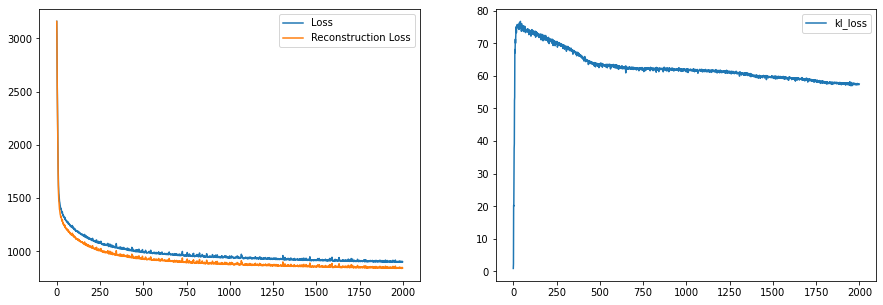

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

#Plot Loss & Reconstruction Loss
plt.subplot(1,2,1)
plt.plot(epoch_range, loss, label="Loss")
plt.plot(epoch_range, r_loss, label="Reconstruction Loss")
plt.legend(loc="upper right")

#Plot kl_loss
plt.subplot(1,2,2)
plt.plot(epoch_range, kl_loss, label="kl_loss")
plt.legend(loc="upper right")


plt.show()

In [15]:
res = vae.encoder.predict(X_st)

In [36]:
res[0].shape

(2550, 64)

In [17]:
import matplotlib.image as mpimg

In [78]:
res_f = vae.decoder.predict(res[2])

In [19]:
res_f[0][0]

array([[0.2976402 , 0.21214461, 0.12714824],
       [0.28802344, 0.18942228, 0.11618245],
       [0.29740113, 0.19919339, 0.12651873],
       [0.28195307, 0.19971296, 0.1262205 ],
       [0.27050453, 0.18921128, 0.11036536],
       [0.28370017, 0.19511575, 0.11447662],
       [0.2854606 , 0.19721761, 0.12076139],
       [0.28423345, 0.19708622, 0.11080131],
       [0.27664435, 0.19037089, 0.1002233 ],
       [0.29495472, 0.19649512, 0.10530677],
       [0.29424092, 0.19553536, 0.10738522],
       [0.2591611 , 0.17892373, 0.09964892],
       [0.25628787, 0.17769325, 0.09885466],
       [0.2689705 , 0.18205631, 0.10700864],
       [0.25947678, 0.1779997 , 0.10867614],
       [0.2454662 , 0.16669554, 0.09633738],
       [0.25774544, 0.17412749, 0.09714502],
       [0.27502936, 0.1779722 , 0.1023663 ],
       [0.2907496 , 0.18715483, 0.10698819],
       [0.2828325 , 0.18109101, 0.09949636],
       [0.2892114 , 0.17939997, 0.09458482],
       [0.29697546, 0.17995185, 0.09934086],
       [0.

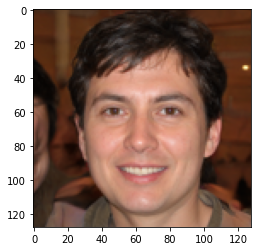

In [80]:
plt.imshow(y[0])

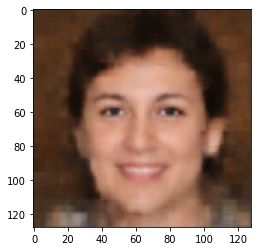

In [81]:
plt.imshow(res_f[0])

# Saving Models

In [7]:
from icangetyoursmile.utils import save_model

## Encoder

In [23]:
save_model(vae.encoder, "Vae_encoder_2000")

2022-03-08 08:14:20.433677: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_models/Vae_encoder_2000/assets


## Decoder

In [24]:
save_model(vae.decoder, "Vae_decoder_2000")

INFO:tensorflow:Assets written to: ./saved_models/Vae_decoder_2000/assets


# Loading Models

In [8]:
from icangetyoursmile.utils import loading_model

In [9]:
vae_encoder_2000 = loading_model("Vae_encoder_2000")

2022-03-08 23:25:27.520713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-08 23:25:27.531937: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 23:25:27.532656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-08 23:25:27.533104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-08 23:25:27.534134: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [10]:
vae_decoder_2000 = loading_model("Vae_decoder_2000")

In [52]:
res2 = vae_encoder_2000.predict(X_st)

In [53]:
res2_f = vae_decoder_2000.predict(res2[0])

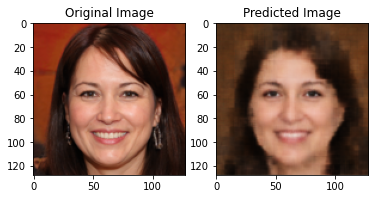

In [83]:
plt.subplot(1,2,1)
plt.imshow(y[9])
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(res2_f[9])
plt.title("Predicted Image")

plt.show()

# Refit Model loaded

In [11]:
vae2 = VAE(vae_encoder_2000,vae_decoder_2000)
vae2.compile(optimizer=keras.optimizers.Adam())

In [13]:
history2 = vae2.fit(X_st, epochs=2000, batch_size=128)

Epoch 1/2000
20/20 [==============================] - 16s 731ms/step - loss: 1670.9007 - reconstruction_loss: 1468.1829 - kl_loss: 53.4820
Epoch 2/2000
20/20 [==============================] - 14s 718ms/step - loss: 1197.7015 - reconstruction_loss: 1102.1106 - kl_loss: 47.4494
Epoch 3/2000
20/20 [==============================] - 14s 711ms/step - loss: 1034.4995 - reconstruction_loss: 960.4553 - kl_loss: 50.5533
Epoch 4/2000
20/20 [==============================] - 14s 720ms/step - loss: 945.3914 - reconstruction_loss: 881.7775 - kl_loss: 55.1998
Epoch 5/2000
20/20 [==============================] - 14s 712ms/step - loss: 909.0101 - reconstruction_loss: 850.1802 - kl_loss: 57.4988
Epoch 6/2000
20/20 [==============================] - 14s 716ms/step - loss: 899.4929 - reconstruction_loss: 840.8133 - kl_loss: 57.4846
Epoch 7/2000
20/20 [==============================] - 15s 723ms/step - loss: 899.9288 - reconstruction_loss: 838.3840 - kl_loss: 57.4743
Epoch 8/2000
20/20 [================

20/20 [==============================] - 15s 747ms/step - loss: 892.6203 - reconstruction_loss: 833.0679 - kl_loss: 58.7773
Epoch 61/2000
20/20 [==============================] - 14s 723ms/step - loss: 887.1863 - reconstruction_loss: 831.1285 - kl_loss: 58.7019
Epoch 62/2000
20/20 [==============================] - 14s 718ms/step - loss: 888.4024 - reconstruction_loss: 830.0345 - kl_loss: 58.9636
Epoch 63/2000
20/20 [==============================] - 15s 726ms/step - loss: 896.0658 - reconstruction_loss: 841.0734 - kl_loss: 58.7784
Epoch 64/2000
20/20 [==============================] - 14s 715ms/step - loss: 898.6189 - reconstruction_loss: 839.7760 - kl_loss: 58.7527
Epoch 65/2000
20/20 [==============================] - 14s 713ms/step - loss: 893.0645 - reconstruction_loss: 831.7454 - kl_loss: 59.1479
Epoch 66/2000
20/20 [==============================] - 14s 724ms/step - loss: 887.3099 - reconstruction_loss: 830.3444 - kl_loss: 58.9907
Epoch 67/2000
20/20 [===========================

20/20 [==============================] - 16s 800ms/step - loss: 896.3302 - reconstruction_loss: 834.4049 - kl_loss: 58.5250
Epoch 120/2000
20/20 [==============================] - 16s 799ms/step - loss: 883.8279 - reconstruction_loss: 830.9330 - kl_loss: 58.7031
Epoch 121/2000
20/20 [==============================] - 16s 806ms/step - loss: 881.9023 - reconstruction_loss: 825.5706 - kl_loss: 59.0161
Epoch 122/2000
20/20 [==============================] - 16s 787ms/step - loss: 881.2632 - reconstruction_loss: 824.5700 - kl_loss: 58.8961
Epoch 123/2000
20/20 [==============================] - 16s 777ms/step - loss: 882.9673 - reconstruction_loss: 831.7575 - kl_loss: 58.7454
Epoch 124/2000
20/20 [==============================] - 16s 777ms/step - loss: 891.0821 - reconstruction_loss: 837.1237 - kl_loss: 58.4057
Epoch 125/2000
20/20 [==============================] - 15s 765ms/step - loss: 885.3865 - reconstruction_loss: 826.8805 - kl_loss: 58.5335
Epoch 126/2000
20/20 [====================

20/20 [==============================] - 15s 765ms/step - loss: 883.3852 - reconstruction_loss: 829.3823 - kl_loss: 58.5158
Epoch 179/2000
20/20 [==============================] - 17s 830ms/step - loss: 879.7999 - reconstruction_loss: 822.8752 - kl_loss: 58.7384
Epoch 180/2000
20/20 [==============================] - 16s 785ms/step - loss: 885.6611 - reconstruction_loss: 824.1846 - kl_loss: 58.3930
Epoch 181/2000
20/20 [==============================] - 15s 761ms/step - loss: 874.9171 - reconstruction_loss: 819.6794 - kl_loss: 58.6656
Epoch 182/2000
20/20 [==============================] - 15s 768ms/step - loss: 879.2782 - reconstruction_loss: 820.4777 - kl_loss: 58.3968
Epoch 183/2000
20/20 [==============================] - 15s 774ms/step - loss: 875.5685 - reconstruction_loss: 823.0782 - kl_loss: 58.3501
Epoch 184/2000
20/20 [==============================] - 15s 753ms/step - loss: 877.1904 - reconstruction_loss: 817.5026 - kl_loss: 58.3949
Epoch 185/2000
20/20 [====================

20/20 [==============================] - 15s 761ms/step - loss: 879.0960 - reconstruction_loss: 818.7628 - kl_loss: 58.3325
Epoch 238/2000
20/20 [==============================] - 15s 763ms/step - loss: 875.6368 - reconstruction_loss: 818.6354 - kl_loss: 58.6224
Epoch 239/2000
20/20 [==============================] - 16s 788ms/step - loss: 880.7600 - reconstruction_loss: 824.4478 - kl_loss: 57.8520
Epoch 240/2000
20/20 [==============================] - 15s 740ms/step - loss: 881.3906 - reconstruction_loss: 822.4348 - kl_loss: 58.4589
Epoch 241/2000
20/20 [==============================] - 15s 761ms/step - loss: 873.9493 - reconstruction_loss: 818.2058 - kl_loss: 58.6595
Epoch 242/2000
20/20 [==============================] - 15s 758ms/step - loss: 868.2989 - reconstruction_loss: 815.4496 - kl_loss: 58.6507
Epoch 243/2000
20/20 [==============================] - 15s 760ms/step - loss: 871.6263 - reconstruction_loss: 815.2645 - kl_loss: 58.6266
Epoch 244/2000
20/20 [====================

20/20 [==============================] - 16s 789ms/step - loss: 880.3398 - reconstruction_loss: 821.4404 - kl_loss: 58.0384
Epoch 297/2000
20/20 [==============================] - 16s 787ms/step - loss: 870.4101 - reconstruction_loss: 816.3692 - kl_loss: 58.3332
Epoch 298/2000
20/20 [==============================] - 16s 786ms/step - loss: 871.4665 - reconstruction_loss: 814.0800 - kl_loss: 58.1884
Epoch 299/2000
20/20 [==============================] - 16s 802ms/step - loss: 864.7509 - reconstruction_loss: 815.4423 - kl_loss: 58.2649
Epoch 300/2000
20/20 [==============================] - 16s 774ms/step - loss: 886.5686 - reconstruction_loss: 824.4363 - kl_loss: 58.0072
Epoch 301/2000
20/20 [==============================] - 15s 754ms/step - loss: 873.8010 - reconstruction_loss: 817.0735 - kl_loss: 58.2234
Epoch 302/2000
20/20 [==============================] - 15s 767ms/step - loss: 870.0675 - reconstruction_loss: 814.3051 - kl_loss: 58.0078
Epoch 303/2000
20/20 [====================

20/20 [==============================] - 16s 824ms/step - loss: 867.3323 - reconstruction_loss: 808.7916 - kl_loss: 57.9094
Epoch 356/2000
20/20 [==============================] - 17s 867ms/step - loss: 862.7098 - reconstruction_loss: 809.1663 - kl_loss: 57.9235
Epoch 357/2000
20/20 [==============================] - 16s 811ms/step - loss: 866.7600 - reconstruction_loss: 811.1940 - kl_loss: 57.8364
Epoch 358/2000
20/20 [==============================] - 16s 799ms/step - loss: 868.9398 - reconstruction_loss: 812.4435 - kl_loss: 57.7740
Epoch 359/2000
20/20 [==============================] - 17s 843ms/step - loss: 861.5549 - reconstruction_loss: 808.0342 - kl_loss: 57.8061
Epoch 360/2000
20/20 [==============================] - 16s 822ms/step - loss: 868.1965 - reconstruction_loss: 813.3000 - kl_loss: 57.9750
Epoch 361/2000
20/20 [==============================] - 17s 832ms/step - loss: 869.3049 - reconstruction_loss: 810.2791 - kl_loss: 57.9451
Epoch 362/2000
20/20 [====================

20/20 [==============================] - 16s 784ms/step - loss: 870.6324 - reconstruction_loss: 808.2346 - kl_loss: 57.8665
Epoch 415/2000
20/20 [==============================] - 16s 787ms/step - loss: 862.1145 - reconstruction_loss: 806.6173 - kl_loss: 57.5951
Epoch 416/2000
20/20 [==============================] - 16s 790ms/step - loss: 871.7726 - reconstruction_loss: 814.3287 - kl_loss: 57.7084
Epoch 417/2000
20/20 [==============================] - 16s 794ms/step - loss: 880.1187 - reconstruction_loss: 823.7256 - kl_loss: 57.2597
Epoch 418/2000
20/20 [==============================] - 16s 777ms/step - loss: 869.0981 - reconstruction_loss: 811.8231 - kl_loss: 57.4607
Epoch 419/2000
20/20 [==============================] - 15s 772ms/step - loss: 866.5998 - reconstruction_loss: 809.7793 - kl_loss: 57.8290
Epoch 420/2000
20/20 [==============================] - 15s 772ms/step - loss: 865.8648 - reconstruction_loss: 808.1649 - kl_loss: 57.6299
Epoch 421/2000
20/20 [====================

20/20 [==============================] - 15s 766ms/step - loss: 871.0013 - reconstruction_loss: 816.1180 - kl_loss: 57.5270
Epoch 474/2000
20/20 [==============================] - 15s 768ms/step - loss: 868.7108 - reconstruction_loss: 811.1272 - kl_loss: 57.5255
Epoch 475/2000
20/20 [==============================] - 15s 755ms/step - loss: 872.3318 - reconstruction_loss: 815.2607 - kl_loss: 57.4309
Epoch 476/2000
20/20 [==============================] - 16s 774ms/step - loss: 867.9747 - reconstruction_loss: 808.5137 - kl_loss: 57.3934
Epoch 477/2000
20/20 [==============================] - 15s 759ms/step - loss: 864.4779 - reconstruction_loss: 811.4744 - kl_loss: 57.5384
Epoch 478/2000
20/20 [==============================] - 15s 764ms/step - loss: 864.0858 - reconstruction_loss: 807.6133 - kl_loss: 57.5202
Epoch 479/2000
20/20 [==============================] - 15s 756ms/step - loss: 859.6552 - reconstruction_loss: 807.8273 - kl_loss: 57.6142
Epoch 480/2000
20/20 [====================

20/20 [==============================] - 15s 773ms/step - loss: 861.0031 - reconstruction_loss: 807.7430 - kl_loss: 57.6939
Epoch 533/2000
20/20 [==============================] - 16s 787ms/step - loss: 861.9437 - reconstruction_loss: 805.6187 - kl_loss: 57.3462
Epoch 534/2000
20/20 [==============================] - 16s 799ms/step - loss: 856.2506 - reconstruction_loss: 805.7222 - kl_loss: 57.6153
Epoch 535/2000
20/20 [==============================] - 15s 761ms/step - loss: 858.1554 - reconstruction_loss: 805.9867 - kl_loss: 57.5114
Epoch 536/2000
20/20 [==============================] - 15s 766ms/step - loss: 862.3852 - reconstruction_loss: 804.8612 - kl_loss: 57.4058
Epoch 537/2000
20/20 [==============================] - 15s 756ms/step - loss: 862.4685 - reconstruction_loss: 802.3852 - kl_loss: 57.8334
Epoch 538/2000
20/20 [==============================] - 15s 761ms/step - loss: 861.8937 - reconstruction_loss: 803.9203 - kl_loss: 57.5012
Epoch 539/2000
20/20 [====================

20/20 [==============================] - 15s 761ms/step - loss: 864.7959 - reconstruction_loss: 805.1219 - kl_loss: 57.7211
Epoch 592/2000
20/20 [==============================] - 15s 767ms/step - loss: 859.8702 - reconstruction_loss: 803.8785 - kl_loss: 57.6732
Epoch 593/2000
20/20 [==============================] - 15s 764ms/step - loss: 861.7727 - reconstruction_loss: 804.8092 - kl_loss: 57.6329
Epoch 594/2000
20/20 [==============================] - 16s 779ms/step - loss: 856.5637 - reconstruction_loss: 804.8470 - kl_loss: 57.6850
Epoch 595/2000
20/20 [==============================] - 15s 765ms/step - loss: 864.7237 - reconstruction_loss: 806.8448 - kl_loss: 57.4498
Epoch 596/2000
20/20 [==============================] - 16s 775ms/step - loss: 857.9307 - reconstruction_loss: 802.1698 - kl_loss: 57.7319
Epoch 597/2000
20/20 [==============================] - 15s 747ms/step - loss: 865.1840 - reconstruction_loss: 803.4883 - kl_loss: 57.5824
Epoch 598/2000
20/20 [====================

20/20 [==============================] - 16s 790ms/step - loss: 862.1569 - reconstruction_loss: 807.3643 - kl_loss: 57.5341
Epoch 651/2000
20/20 [==============================] - 16s 785ms/step - loss: 860.0995 - reconstruction_loss: 802.7417 - kl_loss: 57.5626
Epoch 652/2000
20/20 [==============================] - 15s 772ms/step - loss: 856.7127 - reconstruction_loss: 799.5350 - kl_loss: 57.8913
Epoch 653/2000
20/20 [==============================] - 15s 752ms/step - loss: 865.5595 - reconstruction_loss: 804.6879 - kl_loss: 57.6475
Epoch 654/2000
20/20 [==============================] - 15s 768ms/step - loss: 857.9026 - reconstruction_loss: 803.5475 - kl_loss: 57.5546
Epoch 655/2000
20/20 [==============================] - 15s 749ms/step - loss: 870.7660 - reconstruction_loss: 808.4961 - kl_loss: 57.5663
Epoch 656/2000
20/20 [==============================] - 15s 743ms/step - loss: 860.1966 - reconstruction_loss: 803.5386 - kl_loss: 57.9282
Epoch 657/2000
20/20 [====================

20/20 [==============================] - 15s 764ms/step - loss: 867.3142 - reconstruction_loss: 813.4974 - kl_loss: 57.2840
Epoch 710/2000
20/20 [==============================] - 16s 776ms/step - loss: 869.2354 - reconstruction_loss: 814.2795 - kl_loss: 57.4143
Epoch 711/2000
20/20 [==============================] - 15s 746ms/step - loss: 862.0431 - reconstruction_loss: 806.4144 - kl_loss: 57.4129
Epoch 712/2000
20/20 [==============================] - 15s 746ms/step - loss: 874.7726 - reconstruction_loss: 813.3228 - kl_loss: 57.4219
Epoch 713/2000
20/20 [==============================] - 15s 768ms/step - loss: 860.9313 - reconstruction_loss: 804.6110 - kl_loss: 57.5541
Epoch 714/2000
20/20 [==============================] - 15s 751ms/step - loss: 858.8929 - reconstruction_loss: 806.7581 - kl_loss: 57.8466
Epoch 715/2000
20/20 [==============================] - 15s 760ms/step - loss: 853.8616 - reconstruction_loss: 801.4229 - kl_loss: 57.3541
Epoch 716/2000
20/20 [====================

20/20 [==============================] - 16s 777ms/step - loss: 862.2282 - reconstruction_loss: 808.4366 - kl_loss: 57.4637
Epoch 769/2000
20/20 [==============================] - 16s 787ms/step - loss: 863.1403 - reconstruction_loss: 803.2753 - kl_loss: 57.3212
Epoch 770/2000
20/20 [==============================] - 15s 769ms/step - loss: 866.7659 - reconstruction_loss: 804.1397 - kl_loss: 57.4288
Epoch 771/2000
20/20 [==============================] - 15s 762ms/step - loss: 857.7978 - reconstruction_loss: 801.6085 - kl_loss: 57.5106
Epoch 772/2000
20/20 [==============================] - 15s 768ms/step - loss: 857.1065 - reconstruction_loss: 800.2562 - kl_loss: 57.5602
Epoch 773/2000
20/20 [==============================] - 15s 763ms/step - loss: 856.6854 - reconstruction_loss: 803.9354 - kl_loss: 57.6089
Epoch 774/2000
20/20 [==============================] - 15s 755ms/step - loss: 854.9769 - reconstruction_loss: 803.0884 - kl_loss: 57.7125
Epoch 775/2000
20/20 [====================

20/20 [==============================] - 16s 803ms/step - loss: 853.6400 - reconstruction_loss: 795.2181 - kl_loss: 57.5618
Epoch 828/2000
20/20 [==============================] - 16s 809ms/step - loss: 855.0592 - reconstruction_loss: 799.3501 - kl_loss: 57.4725
Epoch 829/2000
20/20 [==============================] - 15s 752ms/step - loss: 861.7840 - reconstruction_loss: 807.3948 - kl_loss: 57.5406
Epoch 830/2000
20/20 [==============================] - 15s 752ms/step - loss: 865.5586 - reconstruction_loss: 806.1217 - kl_loss: 57.2320
Epoch 831/2000
20/20 [==============================] - 15s 767ms/step - loss: 856.9665 - reconstruction_loss: 803.7534 - kl_loss: 57.6173
Epoch 832/2000
20/20 [==============================] - 15s 772ms/step - loss: 859.9819 - reconstruction_loss: 805.6245 - kl_loss: 57.4261
Epoch 833/2000
20/20 [==============================] - 15s 751ms/step - loss: 861.4061 - reconstruction_loss: 800.8247 - kl_loss: 57.2978
Epoch 834/2000
20/20 [====================

20/20 [==============================] - 15s 767ms/step - loss: 850.1563 - reconstruction_loss: 797.4896 - kl_loss: 57.5162
Epoch 887/2000
20/20 [==============================] - 15s 764ms/step - loss: 862.5021 - reconstruction_loss: 803.2318 - kl_loss: 57.4344
Epoch 888/2000
20/20 [==============================] - 16s 775ms/step - loss: 856.1199 - reconstruction_loss: 798.1815 - kl_loss: 57.6700
Epoch 889/2000
20/20 [==============================] - 15s 744ms/step - loss: 855.0258 - reconstruction_loss: 796.2416 - kl_loss: 57.5552
Epoch 890/2000
20/20 [==============================] - 15s 774ms/step - loss: 853.9985 - reconstruction_loss: 801.0208 - kl_loss: 57.4555
Epoch 891/2000
20/20 [==============================] - 15s 764ms/step - loss: 851.9149 - reconstruction_loss: 797.2371 - kl_loss: 57.4890
Epoch 892/2000
20/20 [==============================] - 15s 766ms/step - loss: 859.3892 - reconstruction_loss: 798.3481 - kl_loss: 57.5454
Epoch 893/2000
20/20 [====================

20/20 [==============================] - 15s 740ms/step - loss: 854.7210 - reconstruction_loss: 794.8300 - kl_loss: 57.5905
Epoch 946/2000
20/20 [==============================] - 15s 759ms/step - loss: 847.2050 - reconstruction_loss: 793.7841 - kl_loss: 57.4926
Epoch 947/2000
20/20 [==============================] - 15s 763ms/step - loss: 857.1913 - reconstruction_loss: 803.7068 - kl_loss: 57.3672
Epoch 948/2000
20/20 [==============================] - 15s 772ms/step - loss: 866.9241 - reconstruction_loss: 812.9053 - kl_loss: 57.1938
Epoch 949/2000
20/20 [==============================] - 15s 752ms/step - loss: 861.7494 - reconstruction_loss: 805.9889 - kl_loss: 57.7355
Epoch 950/2000
20/20 [==============================] - 15s 769ms/step - loss: 856.3722 - reconstruction_loss: 803.5057 - kl_loss: 57.4392
Epoch 951/2000
20/20 [==============================] - 15s 753ms/step - loss: 863.5150 - reconstruction_loss: 804.5128 - kl_loss: 57.4223
Epoch 952/2000
20/20 [====================

20/20 [==============================] - 15s 753ms/step - loss: 851.0685 - reconstruction_loss: 796.1213 - kl_loss: 57.6379
Epoch 1005/2000
20/20 [==============================] - 16s 788ms/step - loss: 857.1466 - reconstruction_loss: 795.6813 - kl_loss: 57.3255
Epoch 1006/2000
20/20 [==============================] - 16s 783ms/step - loss: 850.4265 - reconstruction_loss: 793.9908 - kl_loss: 57.5817
Epoch 1007/2000
20/20 [==============================] - 15s 772ms/step - loss: 851.4928 - reconstruction_loss: 791.8477 - kl_loss: 57.5829
Epoch 1008/2000
20/20 [==============================] - 15s 766ms/step - loss: 848.3877 - reconstruction_loss: 790.5492 - kl_loss: 57.4238
Epoch 1009/2000
20/20 [==============================] - 15s 739ms/step - loss: 850.9997 - reconstruction_loss: 795.3073 - kl_loss: 57.6631
Epoch 1010/2000
20/20 [==============================] - 15s 770ms/step - loss: 863.8732 - reconstruction_loss: 809.3143 - kl_loss: 57.0868
Epoch 1011/2000
20/20 [=============

20/20 [==============================] - 16s 776ms/step - loss: 856.4630 - reconstruction_loss: 799.7143 - kl_loss: 57.3884
Epoch 1063/2000
20/20 [==============================] - 16s 788ms/step - loss: 851.7788 - reconstruction_loss: 795.9642 - kl_loss: 57.4523
Epoch 1064/2000
20/20 [==============================] - 16s 775ms/step - loss: 853.1571 - reconstruction_loss: 792.9547 - kl_loss: 57.6231
Epoch 1065/2000
20/20 [==============================] - 15s 749ms/step - loss: 844.4915 - reconstruction_loss: 793.2108 - kl_loss: 57.4888
Epoch 1066/2000
20/20 [==============================] - 15s 751ms/step - loss: 851.4074 - reconstruction_loss: 798.3624 - kl_loss: 57.3960
Epoch 1067/2000
20/20 [==============================] - 16s 783ms/step - loss: 849.4419 - reconstruction_loss: 795.4799 - kl_loss: 57.5846
Epoch 1068/2000
20/20 [==============================] - 15s 760ms/step - loss: 846.6387 - reconstruction_loss: 791.0101 - kl_loss: 57.5964
Epoch 1069/2000
20/20 [=============

20/20 [==============================] - 15s 759ms/step - loss: 848.0216 - reconstruction_loss: 789.8101 - kl_loss: 57.5054
Epoch 1121/2000
20/20 [==============================] - 15s 758ms/step - loss: 844.7437 - reconstruction_loss: 794.1956 - kl_loss: 57.5442
Epoch 1122/2000
20/20 [==============================] - 15s 772ms/step - loss: 847.2273 - reconstruction_loss: 792.8187 - kl_loss: 57.4601
Epoch 1123/2000
20/20 [==============================] - 15s 757ms/step - loss: 851.5969 - reconstruction_loss: 801.7434 - kl_loss: 57.1520
Epoch 1124/2000
20/20 [==============================] - 15s 753ms/step - loss: 854.4335 - reconstruction_loss: 796.7011 - kl_loss: 57.3876
Epoch 1125/2000
20/20 [==============================] - 15s 763ms/step - loss: 852.5535 - reconstruction_loss: 795.0158 - kl_loss: 57.4990
Epoch 1126/2000
20/20 [==============================] - 15s 756ms/step - loss: 849.9971 - reconstruction_loss: 793.7849 - kl_loss: 57.7693
Epoch 1127/2000
20/20 [=============

20/20 [==============================] - 15s 756ms/step - loss: 854.3190 - reconstruction_loss: 793.9822 - kl_loss: 57.2574
Epoch 1179/2000
20/20 [==============================] - 15s 750ms/step - loss: 850.8895 - reconstruction_loss: 793.0394 - kl_loss: 57.7838
Epoch 1180/2000
20/20 [==============================] - 15s 754ms/step - loss: 845.9793 - reconstruction_loss: 790.2552 - kl_loss: 57.4871
Epoch 1181/2000
20/20 [==============================] - 15s 752ms/step - loss: 845.9242 - reconstruction_loss: 790.6365 - kl_loss: 57.7548
Epoch 1182/2000
20/20 [==============================] - 15s 762ms/step - loss: 848.0812 - reconstruction_loss: 794.3681 - kl_loss: 57.3432
Epoch 1183/2000
20/20 [==============================] - 15s 752ms/step - loss: 856.2985 - reconstruction_loss: 808.2991 - kl_loss: 57.1186
Epoch 1184/2000
20/20 [==============================] - 15s 763ms/step - loss: 859.6353 - reconstruction_loss: 802.0701 - kl_loss: 57.0842
Epoch 1185/2000
20/20 [=============

20/20 [==============================] - 15s 763ms/step - loss: 848.6668 - reconstruction_loss: 795.7535 - kl_loss: 57.3081
Epoch 1237/2000
20/20 [==============================] - 15s 763ms/step - loss: 852.6578 - reconstruction_loss: 803.7614 - kl_loss: 57.3699
Epoch 1238/2000
20/20 [==============================] - 15s 768ms/step - loss: 864.0914 - reconstruction_loss: 800.9324 - kl_loss: 57.2062
Epoch 1239/2000
20/20 [==============================] - 15s 762ms/step - loss: 849.4990 - reconstruction_loss: 792.0688 - kl_loss: 57.5823
Epoch 1240/2000
20/20 [==============================] - 15s 754ms/step - loss: 852.6870 - reconstruction_loss: 791.2177 - kl_loss: 57.5933
Epoch 1241/2000
20/20 [==============================] - 15s 770ms/step - loss: 845.4162 - reconstruction_loss: 791.8467 - kl_loss: 57.3455
Epoch 1242/2000
20/20 [==============================] - 15s 753ms/step - loss: 844.4936 - reconstruction_loss: 791.8676 - kl_loss: 57.3310
Epoch 1243/2000
20/20 [=============

20/20 [==============================] - 15s 748ms/step - loss: 846.6282 - reconstruction_loss: 790.0717 - kl_loss: 57.3472
Epoch 1295/2000
20/20 [==============================] - 15s 763ms/step - loss: 845.6220 - reconstruction_loss: 787.7206 - kl_loss: 57.3648
Epoch 1296/2000
20/20 [==============================] - 15s 756ms/step - loss: 844.2251 - reconstruction_loss: 788.6093 - kl_loss: 57.3893
Epoch 1297/2000
20/20 [==============================] - 15s 760ms/step - loss: 843.3776 - reconstruction_loss: 786.1584 - kl_loss: 57.5187
Epoch 1298/2000
20/20 [==============================] - 15s 755ms/step - loss: 847.6159 - reconstruction_loss: 790.1162 - kl_loss: 57.2431
Epoch 1299/2000
20/20 [==============================] - 16s 791ms/step - loss: 849.9979 - reconstruction_loss: 800.6996 - kl_loss: 57.4721
Epoch 1300/2000
20/20 [==============================] - 16s 779ms/step - loss: 858.0315 - reconstruction_loss: 807.6916 - kl_loss: 56.9172
Epoch 1301/2000
20/20 [=============

20/20 [==============================] - 15s 760ms/step - loss: 840.5491 - reconstruction_loss: 787.7965 - kl_loss: 57.4100
Epoch 1353/2000
20/20 [==============================] - 15s 771ms/step - loss: 841.4243 - reconstruction_loss: 786.1821 - kl_loss: 57.4186
Epoch 1354/2000
20/20 [==============================] - 15s 758ms/step - loss: 845.9480 - reconstruction_loss: 787.4499 - kl_loss: 57.3010
Epoch 1355/2000
20/20 [==============================] - 15s 759ms/step - loss: 845.6462 - reconstruction_loss: 787.5696 - kl_loss: 57.4476
Epoch 1356/2000
20/20 [==============================] - 15s 750ms/step - loss: 843.8652 - reconstruction_loss: 787.0051 - kl_loss: 57.4000
Epoch 1357/2000
20/20 [==============================] - 15s 766ms/step - loss: 844.3225 - reconstruction_loss: 790.4534 - kl_loss: 57.2790
Epoch 1358/2000
20/20 [==============================] - 15s 752ms/step - loss: 850.8873 - reconstruction_loss: 796.3723 - kl_loss: 57.0474
Epoch 1359/2000
20/20 [=============

20/20 [==============================] - 15s 761ms/step - loss: 845.6275 - reconstruction_loss: 785.3594 - kl_loss: 57.3783
Epoch 1411/2000
20/20 [==============================] - 15s 753ms/step - loss: 850.9999 - reconstruction_loss: 791.7037 - kl_loss: 57.1672
Epoch 1412/2000
20/20 [==============================] - 15s 751ms/step - loss: 846.9542 - reconstruction_loss: 795.4156 - kl_loss: 57.1277
Epoch 1413/2000
20/20 [==============================] - 15s 765ms/step - loss: 846.2489 - reconstruction_loss: 790.9686 - kl_loss: 57.4179
Epoch 1414/2000
20/20 [==============================] - 15s 754ms/step - loss: 848.2806 - reconstruction_loss: 790.2933 - kl_loss: 57.2899
Epoch 1415/2000
20/20 [==============================] - 15s 765ms/step - loss: 846.1126 - reconstruction_loss: 786.8632 - kl_loss: 57.5887
Epoch 1416/2000
20/20 [==============================] - 15s 752ms/step - loss: 844.6995 - reconstruction_loss: 791.1392 - kl_loss: 57.1355
Epoch 1417/2000
20/20 [=============

20/20 [==============================] - 15s 747ms/step - loss: 845.3837 - reconstruction_loss: 789.5818 - kl_loss: 57.2413
Epoch 1469/2000
20/20 [==============================] - 15s 756ms/step - loss: 847.2843 - reconstruction_loss: 790.5281 - kl_loss: 57.0348
Epoch 1470/2000
20/20 [==============================] - 15s 746ms/step - loss: 849.1277 - reconstruction_loss: 792.9979 - kl_loss: 57.1244
Epoch 1471/2000
20/20 [==============================] - 15s 762ms/step - loss: 843.9194 - reconstruction_loss: 788.9313 - kl_loss: 57.1441
Epoch 1472/2000
20/20 [==============================] - 15s 747ms/step - loss: 843.8673 - reconstruction_loss: 788.5417 - kl_loss: 57.0792
Epoch 1473/2000
20/20 [==============================] - 15s 769ms/step - loss: 847.0388 - reconstruction_loss: 787.8545 - kl_loss: 57.2765
Epoch 1474/2000
20/20 [==============================] - 15s 736ms/step - loss: 840.7719 - reconstruction_loss: 788.7205 - kl_loss: 57.1906
Epoch 1475/2000
20/20 [=============

20/20 [==============================] - 15s 753ms/step - loss: 842.7248 - reconstruction_loss: 787.1664 - kl_loss: 57.2987
Epoch 1527/2000
20/20 [==============================] - 15s 759ms/step - loss: 857.9428 - reconstruction_loss: 794.3997 - kl_loss: 56.9838
Epoch 1528/2000
20/20 [==============================] - 15s 754ms/step - loss: 847.4030 - reconstruction_loss: 791.6650 - kl_loss: 57.2012
Epoch 1529/2000
20/20 [==============================] - 15s 746ms/step - loss: 840.9356 - reconstruction_loss: 788.4901 - kl_loss: 57.2074
Epoch 1530/2000
20/20 [==============================] - 15s 746ms/step - loss: 843.5532 - reconstruction_loss: 786.4346 - kl_loss: 57.0305
Epoch 1531/2000
20/20 [==============================] - 15s 751ms/step - loss: 840.7643 - reconstruction_loss: 785.0809 - kl_loss: 56.9816
Epoch 1532/2000
20/20 [==============================] - 16s 790ms/step - loss: 846.6642 - reconstruction_loss: 789.7250 - kl_loss: 57.1452
Epoch 1533/2000
20/20 [=============

20/20 [==============================] - 15s 763ms/step - loss: 844.7849 - reconstruction_loss: 790.8038 - kl_loss: 56.9348
Epoch 1585/2000
20/20 [==============================] - 15s 754ms/step - loss: 844.5459 - reconstruction_loss: 785.5057 - kl_loss: 57.0630
Epoch 1586/2000
20/20 [==============================] - 15s 749ms/step - loss: 851.0369 - reconstruction_loss: 796.3108 - kl_loss: 56.7319
Epoch 1587/2000
20/20 [==============================] - 15s 754ms/step - loss: 844.7886 - reconstruction_loss: 786.2488 - kl_loss: 57.1254
Epoch 1588/2000
20/20 [==============================] - 15s 764ms/step - loss: 845.2691 - reconstruction_loss: 785.8411 - kl_loss: 56.9796
Epoch 1589/2000
20/20 [==============================] - 15s 757ms/step - loss: 836.6853 - reconstruction_loss: 788.6141 - kl_loss: 56.9416
Epoch 1590/2000
20/20 [==============================] - 15s 763ms/step - loss: 843.0108 - reconstruction_loss: 784.1871 - kl_loss: 57.0622
Epoch 1591/2000
20/20 [=============

20/20 [==============================] - 15s 756ms/step - loss: 852.8084 - reconstruction_loss: 789.1257 - kl_loss: 56.7978
Epoch 1643/2000
20/20 [==============================] - 15s 749ms/step - loss: 842.5094 - reconstruction_loss: 784.3358 - kl_loss: 57.1822
Epoch 1644/2000
20/20 [==============================] - 15s 755ms/step - loss: 842.8234 - reconstruction_loss: 786.5213 - kl_loss: 56.9301
Epoch 1645/2000
20/20 [==============================] - 15s 755ms/step - loss: 844.5111 - reconstruction_loss: 788.7873 - kl_loss: 56.7728
Epoch 1646/2000
20/20 [==============================] - 15s 767ms/step - loss: 845.3225 - reconstruction_loss: 787.3290 - kl_loss: 56.8638
Epoch 1647/2000
20/20 [==============================] - 15s 749ms/step - loss: 845.3681 - reconstruction_loss: 787.3611 - kl_loss: 56.8732
Epoch 1648/2000
20/20 [==============================] - 15s 755ms/step - loss: 844.3220 - reconstruction_loss: 788.0045 - kl_loss: 56.9354
Epoch 1649/2000
20/20 [=============

20/20 [==============================] - 15s 768ms/step - loss: 844.1524 - reconstruction_loss: 791.5646 - kl_loss: 56.8731
Epoch 1701/2000
20/20 [==============================] - 15s 743ms/step - loss: 856.6858 - reconstruction_loss: 804.8900 - kl_loss: 56.3541
Epoch 1702/2000
20/20 [==============================] - 15s 768ms/step - loss: 850.2897 - reconstruction_loss: 796.0725 - kl_loss: 56.7124
Epoch 1703/2000
20/20 [==============================] - 15s 752ms/step - loss: 856.1313 - reconstruction_loss: 795.4779 - kl_loss: 56.7850
Epoch 1704/2000
20/20 [==============================] - 15s 770ms/step - loss: 841.1070 - reconstruction_loss: 784.8732 - kl_loss: 56.6988
Epoch 1705/2000
20/20 [==============================] - 15s 755ms/step - loss: 841.9962 - reconstruction_loss: 786.8390 - kl_loss: 57.1294
Epoch 1706/2000
20/20 [==============================] - 15s 763ms/step - loss: 838.5301 - reconstruction_loss: 782.7111 - kl_loss: 56.7307
Epoch 1707/2000
20/20 [=============

20/20 [==============================] - 16s 779ms/step - loss: 839.2663 - reconstruction_loss: 785.0161 - kl_loss: 56.8185
Epoch 1759/2000
20/20 [==============================] - 15s 749ms/step - loss: 846.0418 - reconstruction_loss: 788.6511 - kl_loss: 56.4860
Epoch 1760/2000
20/20 [==============================] - 15s 760ms/step - loss: 842.4895 - reconstruction_loss: 786.9285 - kl_loss: 56.4432
Epoch 1761/2000
20/20 [==============================] - 15s 763ms/step - loss: 843.4941 - reconstruction_loss: 786.5234 - kl_loss: 56.5267
Epoch 1762/2000
20/20 [==============================] - 16s 777ms/step - loss: 843.3080 - reconstruction_loss: 786.3771 - kl_loss: 56.7476
Epoch 1763/2000
20/20 [==============================] - 15s 745ms/step - loss: 843.5547 - reconstruction_loss: 783.8464 - kl_loss: 56.4630
Epoch 1764/2000
20/20 [==============================] - 15s 766ms/step - loss: 840.9897 - reconstruction_loss: 790.8001 - kl_loss: 56.5021
Epoch 1765/2000
20/20 [=============

20/20 [==============================] - 15s 765ms/step - loss: 837.5733 - reconstruction_loss: 785.1309 - kl_loss: 56.4318
Epoch 1817/2000
20/20 [==============================] - 15s 754ms/step - loss: 843.7091 - reconstruction_loss: 788.4803 - kl_loss: 56.1672
Epoch 1818/2000
20/20 [==============================] - 15s 764ms/step - loss: 842.8112 - reconstruction_loss: 785.6141 - kl_loss: 56.4077
Epoch 1819/2000
20/20 [==============================] - 15s 752ms/step - loss: 845.2360 - reconstruction_loss: 783.0195 - kl_loss: 56.5572
Epoch 1820/2000
20/20 [==============================] - 15s 773ms/step - loss: 837.3890 - reconstruction_loss: 781.2756 - kl_loss: 56.2331
Epoch 1821/2000
20/20 [==============================] - 15s 755ms/step - loss: 837.1799 - reconstruction_loss: 784.5435 - kl_loss: 56.2696
Epoch 1822/2000
20/20 [==============================] - 15s 769ms/step - loss: 839.9393 - reconstruction_loss: 782.4380 - kl_loss: 56.1764
Epoch 1823/2000
20/20 [=============

20/20 [==============================] - 15s 757ms/step - loss: 845.3362 - reconstruction_loss: 783.8176 - kl_loss: 55.8047
Epoch 1875/2000
20/20 [==============================] - 15s 750ms/step - loss: 838.0949 - reconstruction_loss: 781.6068 - kl_loss: 56.1928
Epoch 1876/2000
20/20 [==============================] - 15s 758ms/step - loss: 837.6515 - reconstruction_loss: 781.4795 - kl_loss: 55.8509
Epoch 1877/2000
20/20 [==============================] - 15s 744ms/step - loss: 837.8602 - reconstruction_loss: 783.6691 - kl_loss: 55.9739
Epoch 1878/2000
20/20 [==============================] - 15s 753ms/step - loss: 841.3651 - reconstruction_loss: 787.7951 - kl_loss: 55.8319
Epoch 1879/2000
20/20 [==============================] - 15s 750ms/step - loss: 848.3445 - reconstruction_loss: 795.1780 - kl_loss: 55.6267
Epoch 1880/2000
20/20 [==============================] - 15s 765ms/step - loss: 856.5706 - reconstruction_loss: 800.7503 - kl_loss: 55.6379
Epoch 1881/2000
20/20 [=============

20/20 [==============================] - 15s 763ms/step - loss: 837.2068 - reconstruction_loss: 784.3085 - kl_loss: 55.5608
Epoch 1933/2000
20/20 [==============================] - 15s 759ms/step - loss: 834.8504 - reconstruction_loss: 781.5980 - kl_loss: 55.7168
Epoch 1934/2000
20/20 [==============================] - 15s 763ms/step - loss: 835.3978 - reconstruction_loss: 783.1125 - kl_loss: 55.5809
Epoch 1935/2000
20/20 [==============================] - 15s 756ms/step - loss: 833.4094 - reconstruction_loss: 780.8567 - kl_loss: 55.5814
Epoch 1936/2000
20/20 [==============================] - 15s 770ms/step - loss: 838.0871 - reconstruction_loss: 784.7792 - kl_loss: 55.7989
Epoch 1937/2000
20/20 [==============================] - 15s 765ms/step - loss: 836.2377 - reconstruction_loss: 782.1945 - kl_loss: 55.5408
Epoch 1938/2000
20/20 [==============================] - 15s 769ms/step - loss: 835.8275 - reconstruction_loss: 784.4494 - kl_loss: 55.7723
Epoch 1939/2000
20/20 [=============

20/20 [==============================] - 15s 769ms/step - loss: 838.5065 - reconstruction_loss: 784.2997 - kl_loss: 55.4584
Epoch 1991/2000
20/20 [==============================] - 15s 769ms/step - loss: 834.8877 - reconstruction_loss: 781.3682 - kl_loss: 55.4231
Epoch 1992/2000
20/20 [==============================] - 15s 768ms/step - loss: 843.0855 - reconstruction_loss: 783.7765 - kl_loss: 55.3628
Epoch 1993/2000
20/20 [==============================] - 15s 754ms/step - loss: 835.1108 - reconstruction_loss: 787.6498 - kl_loss: 55.4131
Epoch 1994/2000
20/20 [==============================] - 15s 772ms/step - loss: 851.5672 - reconstruction_loss: 795.4913 - kl_loss: 55.2505
Epoch 1995/2000
20/20 [==============================] - 16s 778ms/step - loss: 842.7328 - reconstruction_loss: 785.8782 - kl_loss: 55.6870
Epoch 1996/2000
20/20 [==============================] - 15s 764ms/step - loss: 835.4902 - reconstruction_loss: 780.5133 - kl_loss: 55.6777
Epoch 1997/2000
20/20 [=============

In [14]:
save_model(vae.encoder, "Vae_encoder_4000")

NameError: name 'vae' is not defined

In [ ]:
save_model(vae.decoder, "Vae_decoder_4000")